In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [2]:
train = pd.read_csv("./exercise_40_train.csv")

Now apply all preprocessing modifications to train and test data

In [3]:
# change 'x7' and 'x19' to continuous variables
train['x7'] = train.x7.str.replace("%",'').astype(np.float64)
train['x19'] = train.x19.str.replace("$",'').astype(np.float64)

# drop column 'x39'
train.drop('x39',axis=1,inplace=True)

# 'x99': missing data gets its own category
train["x99"] = train["x99"].fillna("U")

# 'x3': Set consistent naming convention for days of the week
train['x3'] = train['x3'].str[:3]

# 'x60': Sort Months into "Summer" and "Winter"
month_map = {
        "February":"FebMarApr",
        "March":"FebMarApr",
        "April":"FebMarApr",
        "May":"MayJun",
        "June":"MayJun",
        "September":"SepOctNov",
        "October":"SepOctNov",
        "November":"SepOctNov"
    }
train["x60"] = train['x60'].replace(month_map)

# 'x24': treat missing data as its own category
train["x24"] = train["x24"].fillna("U")

# Group states into VeryHigh, High, Medium, Low, and VeryLow risk
df = train[["x33","y"]].groupby(by='x33',dropna=False).agg(['mean','count'])
df["bin"] = pd.cut(df[("y","mean")], 
    bins=[.03,.105,.13,.16,.19,.34], 
    labels=["VeryLow","Low","Medium","High","VeryHigh"])
state_map = {}
for index, row in df.iterrows():
    state_map[index] = row.bin.iloc[0]
train['x33'] = train['x33'].replace(state_map)

# 'x77': combine 'toyota', 'buick', 'nissan' into single category.
train['x77'] = train["x77"].replace({"toyota":"ToyotaNissanBuick",
                                    "nissan":"ToyotaNissanBuick",
                                    "buick":"ToyotaNissanBuick"})
# 'x77': treat missing data as its own category
train["x77"] = train["x77"].fillna("U")  

Now, standardize all continuous features of training data and use this scale for the testing data. Then fill training and testing NaN's with the meidan value for training data.

In [4]:
train_cat = train.loc[:,train.dtypes==np.object].copy()
train_num = train.loc[:,train.dtypes==np.float64].copy()
y_train = train.y.copy()

# normalize all continuous data
scaler = StandardScaler()
scaler.fit(train_num)
train_num_scal = scaler.transform(train_num)

# fill in all missing continuous data with median of training data
imputer = SimpleImputer(strategy='median')
imputer.fit(train_num_scal)
train_num_scal_tf = pd.DataFrame( imputer.transform(train_num_scal), 
                                 columns = train_num.columns, index = train_num.index )

# get dummy variables
cat_var_ls = [
    'x3_Mon','x3_Tue','x3_Thu','x3_Fri','x3_Sat','x3_Sun',#'x3_Wed',
    'x24_male','x24_U',#'x24_female',
    'x31_yes',#'x31_no',
    'x33_VeryLow','x33_Medium','x33_High','x33_VeryHigh',#'x33_Low',
    'x60_January','x60_FebMarApr','x60_MayJun','x60_July','x60_August','x60_SepOctNov',#'x60_December',
    'x65_allstate', 'x65_esurance', 'x65_farmers','x65_geico',#'x65_progressive'
    'x77_ford','x77_subaru','x77_mercedes','x77_chevrolet','x77_ToyotaNissanBuick',#'x77_U',
    'x93_yes',#'x93_no',
    'x99_U',#'x99_yes',
]
train_cat_dum = pd.get_dummies(train_cat)[cat_var_ls]

train_clean = pd.concat([train_num_scal_tf,train_cat_dum], axis=1)

# Generalized Linear Model Selection

## Logistic Regression 

In [5]:
glm = sm.Logit(y_train,sm.add_constant(train_clean)).fit()
print(glm.summary())

Optimization terminated successfully.
         Current function value: 0.351457
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39881
Method:                           MLE   Df Model:                          118
Date:                Wed, 21 Jul 2021   Pseudo R-squ.:                  0.1512
Time:                        17:50:35   Log-Likelihood:                -14058.
converged:                       True   LL-Null:                       -16563.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -2.3226      0.070    -33.320      0.000      -2.459      -2.

Use backward feature selection with p-value threshold of 0.05 to select relevent features.

In [6]:
threshold = 0.05
ls = [] # list of features to exclude
for i in range(len(train_clean.columns)):
    lm = sm.Logit(y_train, sm.add_constant(train_clean.drop(ls,axis=1))).fit(disp=0)
    ind = lm.pvalues.argmax()
    if lm.pvalues.iloc[ind]>threshold: # add worst feature to list of features to exclude from regression model
        ls.append(lm.pvalues.index[ind])
    else: # if max p-value is smaller than threshold end loop
        break

glm = sm.Logit(y_train, sm.add_constant(train_clean.drop(ls,axis=1))).fit()
print(glm.summary())

Optimization terminated successfully.
         Current function value: 0.352221
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39958
Method:                           MLE   Df Model:                           41
Date:                Wed, 21 Jul 2021   Pseudo R-squ.:                  0.1494
Time:                        17:51:03   Log-Likelihood:                -14089.
converged:                       True   LL-Null:                       -16563.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.2726      0.037    -61.125      0.000      -2.345      -2.200
x5               0.0575

Total number of significant features: 42 (28 continuous variables and 13 categorical features, along with the fitted intercept).

Now, examine how p-value thresholding does on 10-fold cross-validation measuring ROC-AUC score.

In [7]:
def pval_thresholding(X_train, y_train, threshold=0.05):
    ls = [] # list of features to exclude
    for i in range(len(X_train.columns)):
        lm = sm.Logit(y_train, sm.add_constant(X_train.drop(ls,axis=1))).fit(disp=0)
        ind = lm.pvalues.argmax()
        if lm.pvalues.iloc[ind]>threshold: # add worst feature to list of features to exclude from regression model
            ls.append(lm.pvalues.index[ind])
        else: # if max p-value is smaller than threshold end loop
            break
    return ls

In [8]:
cv = StratifiedKFold(n_splits=10)
glm = LogisticRegression(max_iter=10000, penalty='none')
scores = np.zeros(10)
i = 0 # track split
for train_index, test_index in cv.split(train_clean, y_train):
    X_train_train, X_train_test = train_clean.to_numpy()[train_index], train_clean.to_numpy()[test_index]
    y_train_train, y_train_test = y_train[train_index], y_train[test_index]
    glm.fit(X_train_train, y_train_train)
    scores[i] = roc_auc_score(y_train_test, glm.predict_proba(X_train_test)[:,1])
    i+=1
print("CV mean:", scores.mean())
print("CV sd:",scores.std())

CV mean: 0.7643500687374902
CV sd: 0.0126795840074218


## Logistic Regression with Recusive Feature Elimination

Model performance will ultimatly be measured by its ROC-AUC score, therefore the models should be optimized for performance using that metric. The next model will use recursive feature elimination using cross validated ROC-AUC score selection. The output model should then be tuned to perform well on future data as measure by ROC-AUC score.

In [9]:
glm2 = RFECV(LogisticRegression(max_iter=10000),
      scoring = 'roc_auc',
      n_jobs = -1, cv = 10)
glm2.fit(train_clean, y_train)

RFECV(cv=10, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
      scoring='roc_auc')

54 total features selected by RFECV.

In [10]:
rfe_features = train_clean.columns[glm2.support_]
print(rfe_features)

Index(['x5', 'x7', 'x8', 'x11', 'x15', 'x18', 'x19', 'x20', 'x27', 'x28',
       'x36', 'x37', 'x40', 'x41', 'x46', 'x47', 'x51', 'x53', 'x54', 'x61',
       'x62', 'x64', 'x66', 'x70', 'x73', 'x74', 'x82', 'x83', 'x86', 'x87',
       'x89', 'x91', 'x3_Mon', 'x3_Tue', 'x3_Thu', 'x3_Fri', 'x3_Sat',
       'x3_Sun', 'x31_yes', 'x33_VeryLow', 'x33_Medium', 'x33_High',
       'x33_VeryHigh', 'x60_January', 'x60_FebMarApr', 'x60_MayJun',
       'x60_SepOctNov', 'x65_allstate', 'x65_esurance', 'x65_farmers',
       'x65_geico', 'x77_mercedes', 'x93_yes', 'x99_U'],
      dtype='object')


Estimate of ROC-AUC score with 10-fold cross validation.

In [11]:
glm_rfe = LogisticRegression(max_iter=10000)
features = train_clean.columns[glm2.support_]
cross_val = cross_val_score(glm_rfe, train_clean[features], y_train, cv=10, scoring='roc_auc', n_jobs=-1)
print(glm_rfe)
print("CV mean:", cross_val.mean())
print("CV sd:", cross_val.std())

LogisticRegression(max_iter=10000)
CV mean: 0.7665994011036468
CV sd: 0.012970168214183033


## Logistic Regression with Feature Selection using Lasso Penalty

Optimizing LASSO penalization using GridSearchCV.

In [12]:
# First grid search for L1 penalty from 1e-5 to 1e5
glm3 = GridSearchCV(LogisticRegression(max_iter=10000,penalty='l1',solver='liblinear'), 
                    scoring='roc_auc', cv=10,
                    param_grid={'C': [10**i for i in np.linspace(-5,5,11)] }, n_jobs=-1)
glm3.fit(train_clean,y_train)
glm3.best_params_

{'C': 0.1}

Now grid search between 0.01 and 1:

In [13]:
c = glm3.best_params_["C"]
glm3 = GridSearchCV(LogisticRegression(max_iter=1000,penalty='l1',solver='liblinear'), 
                    scoring='roc_auc', cv=10,
                    param_grid={'C': [10**i for i in np.linspace(np.log10(c)-1, np.log10(c)+1,11)] }, n_jobs=-1)
glm3.fit(train_clean,y_train)
glm3.best_params_

{'C': 0.1}

Corresponds to $C = 10^{-1.0}$. Now grid search between $10^{-1.2}$ and $10^{-0.8}$:

In [14]:
c = glm3.best_params_["C"]
glm3 = GridSearchCV(LogisticRegression(max_iter=1000,penalty='l1',solver='liblinear'), 
                    scoring='roc_auc', cv=10,
                    param_grid={'C': [10**i for i in np.linspace(np.log10(c)-0.2,np.log10(c)+0.2,11)] }, n_jobs=-1)
glm3.fit(train_clean,y_train)
glm3.best_params_

{'C': 0.1318256738556407}

Corresponds to $C = 10^{-.88}$. Now grid search between $10^{-.90}$ and $10^{-.86}$:

In [15]:
c = glm3.best_params_["C"]
glm3 = GridSearchCV(LogisticRegression(max_iter=1000,penalty='l1',solver='liblinear'), 
                    scoring='roc_auc', cv=10,
                    param_grid={'C': [10**i for i in np.linspace(np.log10(c)-0.02,np.log10(c)+0.02,11)] }, n_jobs=-1)
glm3.fit(train_clean,y_train)
glm3.best_params_

{'C': 0.1318256738556407}

Best coefficient is $C = 10^{-.90}$. This is what I'll use to fit logistic regression with Lasso regularization:

In [16]:
c = glm3.best_params_["C"]
lasso = LogisticRegression(max_iter=1000,penalty='l1',solver='liblinear',C=c)
lasso.fit(train_clean,y_train)

LogisticRegression(C=0.1318256738556407, max_iter=1000, penalty='l1',
                   solver='liblinear')

In [17]:
cross_val = cross_val_score(lasso, train_clean, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
print(lasso)
print("CV mean:", cross_val.mean())
print("CV sd:", cross_val.std())

LogisticRegression(C=0.1318256738556407, max_iter=1000, penalty='l1',
                   solver='liblinear')
CV mean: 0.7648179352187394
CV sd: 0.012705744872916805


## GLM Model Conclusion

RFECV has the best ROC-AUC score estimate by cross-validation.

# Random Forest

For tree based methods, column 'x33' (US states classified into "VeryLow", "Low", "Medium", "High", "VeryHigh" categories) should be treated as an ordinal variable, rather than one-hot encoding.

In [18]:
x33_categories = ["VeryLow","Low","Medium","High","VeryHigh"]
enc = OrdinalEncoder(categories = [x33_categories])
train_clean_rf = train_clean.drop(["x33_VeryLow","x33_Medium","x33_High","x33_VeryHigh"],axis=1)
train_clean_rf["x33"] = enc.fit_transform(train.x33.to_numpy().reshape(-1,1)).reshape(1,-1)[0]

In [19]:
tree = DecisionTreeClassifier(max_depth=30,min_samples_split=20,min_samples_leaf=7,ccp_alpha=0.00015)
alphas = tree.cost_complexity_pruning_path(train_clean_rf, y_train).ccp_alphas

Determine the best cp_alpha parameter by cross-validation. Use "one-standard-error rule" to select the best ccp_alpha parameter.

In [20]:
bound = 0.00015
cv_mean = []
cv_sd = []
for alpha in alphas[alphas>bound]:
    tr = DecisionTreeClassifier(max_depth=30,min_samples_split=20,min_samples_leaf=7,ccp_alpha=alpha)
    cross_val = cross_val_score(tr, train_clean_rf, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
    cv_mean.append(cross_val.mean())
    cv_sd.append(cross_val.std())
cv_mean = np.array(cv_mean)
cv_sd = np.array(cv_sd)

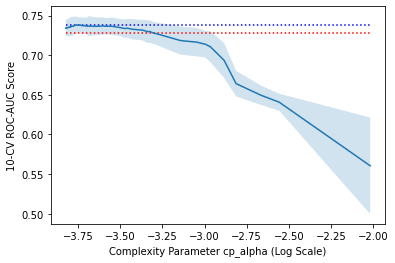

In [21]:
plt.figure()
plt.plot(np.log10(alphas[alphas>bound]), cv_mean)
plt.fill_between(np.log10(alphas[alphas>bound]),cv_mean+cv_sd,cv_mean-cv_sd,alpha=0.2)
plt.hlines(cv_mean[np.argmax(cv_mean)],
    xmin=min(np.log10(alphas[alphas>bound])),xmax=max(np.log10(alphas[alphas>bound])),
             color='b',linestyles="dotted")
plt.hlines(cv_mean[np.argmax(cv_mean)]-cv_sd[np.argmax(cv_mean)],
    xmin=min(np.log10(alphas[alphas>bound])),xmax=max(np.log10(alphas[alphas>bound])),
             color='r',linestyles="dotted")
plt.xlabel("Complexity Parameter cp_alpha (Log Scale)")
plt.ylabel("10-CV ROC-AUC Score")
plt.show()

In [22]:
ind = np.argmax(cv_mean)
print(cv_mean[ind])
print(cv_sd[ind])

0.7381100225988495
0.010614463756229533


In [23]:
onestd = cv_mean>cv_mean[ind]-cv_sd[ind]
# find one standard dev index
ind1sd = onestd[::-1].argmax() + 1
print(ind1sd)
# set complexity parameter
cp = alphas[alphas>bound][-ind1sd]
print(cp)

14
0.00047167223164789294


In [24]:
tree_clf = DecisionTreeClassifier(max_depth=30,min_samples_split=20,min_samples_leaf=7,ccp_alpha=cp)
tree_clf.fit(train_clean_rf,y_train)

DecisionTreeClassifier(ccp_alpha=0.00047167223164789294, max_depth=30,
                       min_samples_leaf=7, min_samples_split=20)

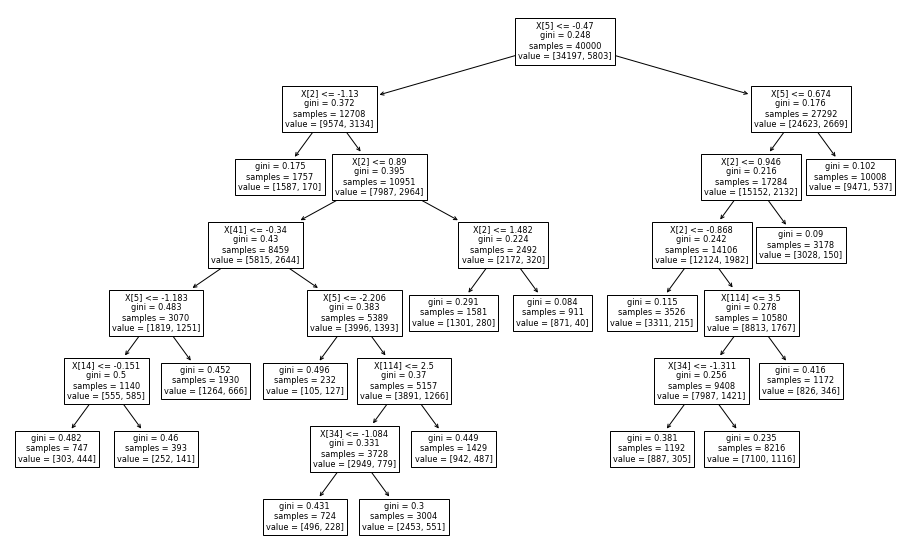

In [25]:
plt.figure(figsize=(16,10))
plot_tree(tree_clf)
plt.show()

Check the ROC-AUC score on training data for a single decision tree:

In [26]:
roc_auc_score(y_train, tree_clf.predict_proba(train_clean_rf)[:,1])

0.7377896373412244

Now, use the parameters to create a random forest classifier:

In [27]:
rf = RandomForestClassifier(n_estimators=500,max_depth=30,min_samples_split=20,
                            min_samples_leaf=7,ccp_alpha=cp,n_jobs=-1,
                            oob_score=True)
cross_val = cross_val_score(rf, train_clean_rf, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
print(rf)
print("CV mean:",cross_val.mean())
print("CV sd:",cross_val.std())

RandomForestClassifier(ccp_alpha=0.00047167223164789294, max_depth=30,
                       min_samples_leaf=7, min_samples_split=20,
                       n_estimators=500, n_jobs=-1, oob_score=True)
CV mean: 0.7636491727664316
CV sd: 0.013823509108935745


Examine feature importance for the random forest classifier. Plot the top 10 most influential features. Note that 'x33', the categorical feature now treated as ordinal, is among the top 5 features identified.

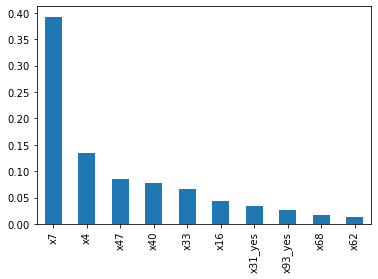

In [30]:
rf.fit(train_clean_rf,y_train)
pd.Series(rf.feature_importances_, index=train_clean_rf.columns).sort_values(ascending=False).iloc[:10].plot(kind='bar')
plt.show()

## AdaBoosting

We'll fit an AdaBoost classifier using max_depth=1 decision trees (stumps) as a weak learner. Cross validation showed trees with max_depth=1 outperformed deeper trees.

In [31]:
ada_clf = GridSearchCV(
    AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1),
        algorithm="SAMME.R"
    ),
    scoring='roc_auc',cv=10, n_jobs=-1,
    param_grid={'n_estimators': [50,100,200,400],
               'learning_rate': [10**i for i in np.linspace(0,-1,6)]}
)
grid_search = ada_clf.fit(train_clean_rf, y_train)
print(grid_search)

print("Best: %f using %s" % (ada_clf.best_score_, ada_clf.best_params_))
means = ada_clf.cv_results_['mean_test_score']
stds = ada_clf.cv_results_['std_test_score']
params = ada_clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

GridSearchCV(cv=10,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1)),
             n_jobs=-1,
             param_grid={'learning_rate': [1.0, 0.6309573444801932,
                                           0.3981071705534972,
                                           0.25118864315095796,
                                           0.15848931924611134, 0.1],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='roc_auc')
Best: 0.804103 using {'learning_rate': 0.25118864315095796, 'n_estimators': 200}
0.793733 (0.008189) with: {'learning_rate': 1.0, 'n_estimators': 50}
0.793148 (0.010280) with: {'learning_rate': 1.0, 'n_estimators': 100}
0.790330 (0.008748) with: {'learning_rate': 1.0, 'n_estimators': 200}
0.785165 (0.009520) with: {'learning_rate': 1.0, 'n_estimators': 400}
0.797736 (0.008751) with: {'learning_rate': 0.6309573444801932, 'n_estimators': 50}
0.798828 (0.008953) with: {'learning_rate': 0.63095734448

In [32]:
ada_clf = GridSearchCV(
    AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1),
        algorithm="SAMME.R"
    ),
    scoring='roc_auc',cv=10, n_jobs=-1,
    param_grid={'n_estimators': [int(10**i) for i in np.linspace(2.5,3.0,5)],
               'learning_rate': [10**i for i in np.linspace(-1,-0.8,2)]}
)
grid_search = ada_clf.fit(train_clean_rf, y_train)
print(grid_search)

print("Best: %f using %s" % (grid_search.best_score_, ada_clf.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

GridSearchCV(cv=10,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1)),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.15848931924611134],
                         'n_estimators': [316, 421, 562, 749, 1000]},
             scoring='roc_auc')
Best: 0.804244 using {'learning_rate': 0.15848931924611134, 'n_estimators': 316}
0.802593 (0.009254) with: {'learning_rate': 0.1, 'n_estimators': 316}
0.803920 (0.009181) with: {'learning_rate': 0.1, 'n_estimators': 421}
0.804110 (0.009024) with: {'learning_rate': 0.1, 'n_estimators': 562}
0.804008 (0.008441) with: {'learning_rate': 0.1, 'n_estimators': 749}
0.801792 (0.007407) with: {'learning_rate': 0.1, 'n_estimators': 1000}
0.804244 (0.009447) with: {'learning_rate': 0.15848931924611134, 'n_estimators': 316}
0.804182 (0.008939) with: {'learning_rate': 0.15848931924611134, 'n_estimators': 421}
0.802917 (0.007765) with: {'learning_rate': 0.15848931924611134, 'n_estimators': 562}

With GridSearchCV, the parameters that performed best by ROC-AUC score were with learning rate 0.1 and 750 estimators. With a large number of estimators the model is very resourse heavy, however some simpler models, e.g. with learning rate 0.63 and only 50 estimators acheive 10-fold cross-validation ROC-AUC scores within one standard deviation of the best score achieved by grid search.

In [33]:
# AdaBoost with large number of classifiers
ada1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
    algorithm="SAMME.R",learning_rate=0.1,n_estimators=750)
ada1.fit(train_clean_rf,y_train)

# AdaBoost classifier with higher learning rate and less classifiersy
ada2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
    algorithm="SAMME.R",learning_rate=10**(-.2),n_estimators=50)
ada2.fit(train_clean_rf,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.6309573444801932)

In [34]:
cross_val = cross_val_score(ada2, train_clean_rf, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
print(ada2)
print("CV mean:",cross_val.mean())
print("CV sd:", cross_val.std())

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.6309573444801932)
CV mean: 0.7977356023307908
CV sd: 0.008751465170972313


In [35]:
cross_val = cross_val_score(ada1, train_clean_rf, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
print(ada1)
print("CV mean:",cross_val.mean())
print("CV sd:",cross_val.std())

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.1, n_estimators=750)
CV mean: 0.8040180855615457
CV sd: 0.008443770842821025


# Conclusion

The goal is to choose the best models to use for classifying the testing data based on ROC-AUC score. Using mean ROC-AUC score over 10-fold CV to infer the generalizability of each model to future data, the best model in the glm family was from recursive feature elimination. This model outperformed both p-value thresholding and Lasso regularization.

Among the other models, the best performance was clearly achieve by AdaBoost, consistently achieving higher ROC-AUC scores than other models. The best model performance was achieved with a small learning rate and large number of estimators. This is the best model in terms of ROC-AUC score by far. However, with the large number of estimators this model is very resource heavy. A simpler AdaBoost model fit with larger learning rate and fewer estimators would require far less computational resources yet achieve nearly the same ROC-AUC score.

In terms of maximizing the ROC-AUC score the best performing model is the more computationally expensive option, but if resources were an issue, a less complex AdaBoost model could be expected to achieve similar performance.